In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from settings  import *
from preprocessing import *
from models import Relative_Positioning, StagerNet
import mne
from dataset import RP_Dataset, WeightedSampler
from train import train_ssl

In [4]:
import torch
from torch.nn import *
from pylab import *
from torch import optim
from torch.utils import data
from torch import nn
from torch.nn.functional import soft_margin_loss

In [5]:
raw = get_raw('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


In [7]:
x = raw["eeg"]

In [12]:
help(mne.RaW.get_data)

AttributeError: module 'mne' has no attribute 'RaW'

In [13]:
def reconstuct_signal(raw, ica):
    """
    a function to get the reconstruct eeg signal from raw using the computed ICs 
    parameters:
    -----------
    - raw : mne RAW object
    - ica : mne ICA object

    
    returns: numpy array
    -------
    """
    signal = ica.apply(raw)
    picks = mne.pick_types(signal.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])
    return signal.get_data(picks)
       
def process(subject):
    """
    a function to get preprocessed eeg signal for a single subject

    """
    # Bandpass filtring 
    raw = get_raw(subject)
    ica = get_ica(subject)
    
    return reconstuct_signal(raw, ica)


In [14]:
eeg_signal = process('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.
Transforming to ICA space (61 components)
Zeroing out 4 ICA components


In [15]:
eeg_signal.shape

(64, 2478166)

In [19]:
subject = '01'
# models params
C = 64
T =1000
M = 200
#training paramms
epochs = 20
batch_size = 40
lr = 1e-3
resume = False
#datasets params
n_train = 4000
n_test = 500
#sampling params
pos= 3000
neg = 7000

s_weights = [0.5, 1-0.5]


In [20]:
print( "Training parameters:")
print("======================")
print(f"- subject: {subject}\n- C : {C}\n- T : {T}\n- M : {M}\n- epochs : {epochs}\n- batch size : {batch_size}\n- lr : {lr}\n- n_train : {n_train}\n- n_test : {n_test}\n- pos : {pos}\n- neg : {neg}")

X = eeg_signal
#split data
split = int(X.shape[1]*0.6)
X_train = X[:, :split]
X_test = X[:, split:]

Training parameters:
- subject: 01
- C : 64
- T : 1000
- M : 200
- epochs : 20
- batch size : 40
- lr : 0.001
- n_train : 4000
- n_test : 500
- pos : 3000
- neg : 7000


In [21]:

#define ssl model
ssl_model = Relative_Positioning(StagerNet,C , T, embedding_dim = M )
ssl_model.to(float)
# datasets
train_dataset =  RP_Dataset(X_train, sampling_params = (pos, neg), temp_len = T ,
                            n_features = C )
test_dataset =  RP_Dataset(X_test, sampling_params = (pos, neg), temp_len = T ,
                            n_features = C )

train_sampler = WeightedSampler(train_dataset, batch_size = batch_size ,size = n_train,  
                          weights = s_weights)
test_sampler = WeightedSampler(test_dataset, batch_size = batch_size ,size = n_test,  
                          weights = s_weights)
samplers = {"train" : train_sampler, "val": test_sampler}


#train ssl 
train_losses, test_losses, model = train_ssl(ssl_model, train_dataset, test_dataset,
                                             samplers,n_epochs=epochs, lr=lr,batch_size= batch_size, 
                                             load_last_saved_model=False, num_workers= 0)




Epoch 1, Test loss 0.0003
Epoch 2, Test loss 0.0003
Epoch 3, Test loss 0.0003
Epoch 4, Test loss 0.0002
Epoch 5, Test loss 0.0002
Epoch 6, Test loss 0.0002
Epoch 7, Test loss 0.0002
Epoch 8, Test loss 0.0002
Epoch 9, Test loss 0.0002
Epoch 10, Test loss 0.0002
Epoch 11, Test loss 0.0002
Epoch 12, Test loss 0.0002
Epoch 13, Test loss 0.0002
Epoch 14, Test loss 0.0002
Epoch 15, Test loss 0.0002
Epoch 16, Test loss 0.0002
Epoch 17, Test loss 0.0002
Epoch 18, Test loss 0.0002
Epoch 19, Test loss 0.0002
Epoch 20, Test loss 0.0002


In [5]:
raw = get_raw('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...


In [7]:
events = mne.find_events(raw, stim_channel='STI 014', output = 'offset')

540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]


In [73]:
meta = load_stimuli_metadata(data_root = METADATA_DIR,version= 2)

In [105]:
def decode_trial_event_type(etype):
    stimulus_id = etype // 10
    condition = etype % 10
    return stimulus_id, condition
def filter_trial_events(events, stimulus_ids='any', conditions='any'):
    filtered = []
    for event in events:
        etype = event[2]
        if etype >= 1000:
            continue

        stimulus_id, condition = decode_trial_event_type(etype)

        if (stimulus_ids == 'any' or stimulus_id in stimulus_ids) and \
                (conditions == 'any' or condition in conditions):
            filtered.append(event)

    return np.asarray(filtered)

In [159]:
import mne
def get_trial_epochs(raw, trial_events, stim_id, condition,
                     subject=None, stimuli_version=None, meta=None,
                     include_cue=False, picks=None, debug=False):

    assert subject is None or stimuli_version is None or meta is None

    if meta is None:
        if stimuli_version is None:
            if subject is None:
                raise RuntimeError('Either meta, stimuli_version or subject has to be specified.')
            else:
                stimuli_version = get_stimuli_version(subject)
        meta = load_stimuli_metadata(data_root = METADATA_DIR, version=stimuli_version)

    events = filter_trial_events(trial_events, [stim_id], [condition])
    
    print(events)
    start = -0.0000001
    if condition in [1,2]: # cued
        if include_cue:
            stop = meta[stim_id]['length_with_cue']
        else:
            # NOTE: start > 0 does not work; need to shift event time
            offset = int(np.floor(meta[stim_id]['length_of_cue'] * raw.info['sfreq']))
            events[:,0] += offset
            stop = meta[stim_id]['length_without_cue']
    else:
        stop = meta[stim_id]['length_without_cue']
    print(start, stop)
    if picks is None:
        # default: all EEG channels including bad/interpolated
        picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=False, stim=False, exclude=[])

    epochs = mne.Epochs(raw, events, None,
                              tmin=start, tmax=stop, preload=True,
                              proj=False, picks=picks, verbose=False)

    

    return epochs

In [22]:
def get_features(subject, stim_id,condition):
    
    raw = get_raw(subject)
    ica = get_ica(subject)
    cleaned_data = reconstuct_signal(raw, ica)
    events = get_events(raw)
    epochs = get_trial_epochs(raw, events, stim_id = stim_id, condition= condition,
                     subject=subject, stimuli_version=None, meta=None,
                     include_cue=True, picks=None, debug=False)
    return epochs
get_features('01', 1,1)

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
Now restoring ICA solution ...
Ready.


MemoryError: Unable to allocate 1.13 GiB for an array with shape (61, 2478166) and data type float64

In [160]:
epochs = get_trial_epochs(raw, events, stim_id = 2, condition= 1,
                     subject='01', stimuli_version=None, meta=None,
                     include_cue=True, picks=None, debug=False)

[[ 209137       0      21]
 [ 467680       0      21]
 [1061772       0      21]
 [1179088       0      21]
 [1793354       0      21]]
-1e-07 9.5011


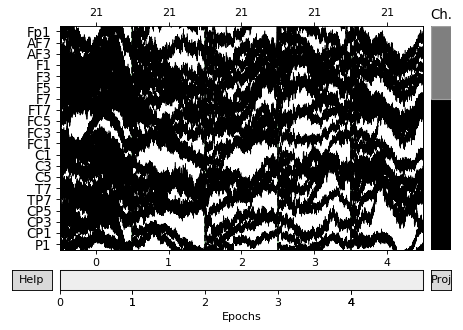

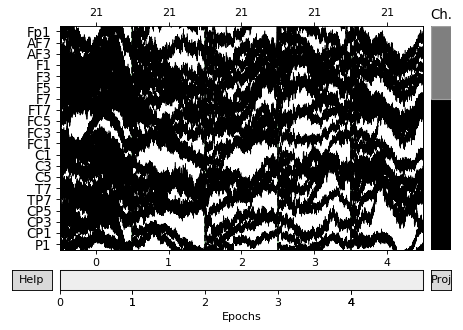

In [161]:
epochs.plot(n_epochs=10)

In [158]:
for epoch in epochs:
    print(epoch.shape)

(64, 4867)
(64, 4867)
(64, 4867)
(64, 4867)
(64, 4867)


In [173]:
eeg_data.shape

(68, 2478166)

In [171]:
x = torch.tensor(epoch)

In [172]:
model(x)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 69 1 69 1, but got 2-dimensional input of size [4867, 1] instead

In [20]:
data_dict = get_Data('01')

Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
540 events found
Event IDs: [  11   12   13   14   21   22   23   24   31   32   33   34   41   42
   43   44  111  112  113  114  121  122  123  124  131  132  133  134
  141  142  143  144  211  212  213  214  221  222  223  224  231  232
  233  234  241  242  243  244 1000 1111 2001]
Opening raw data file /home/brain/openmiir/raw_data/P01-raw.fif...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 64)  idle
    Range : 0 ... 2478165 =      0.000 ...  4840.166 secs
Ready.
Reading 0 ... 2478165  =      0.000 ...  4840.166 secs...
Reading /home/brain/openmiir/eeg/preprocessing/ica/P01-100p_64c-ica.fif ...
Isotrak not found
    Read a total of 1 projection

MemoryError: Unable to allocate 1.13 GiB for an array with shape (61, 2478166) and data type float64

In [61]:
def get_perception_data(eeg_data, events ):
    
    """
    a function to get perception features and target ids from eeg 
    data recording of a single subject using an events array
    returns:
    -------
    a dict with a list of `features` and a list of target ids as values.
    """
    
    start = 0
    features = []
    target_ids = []
    
    for event in events:
        end , event_id = event[0], event[2]
        
        if event_id < 1000: #Event Ids < 1000 are trial labels
            stimulus_id = event_id // 10
            condition = event_id % 10
            
            if condition == 1: # 1: preception trials
                features.append(eeg_data[:,start:end])
                target_ids.append(stimulus_id)
                
        start = end 
    return {"features": features, "targets": target_ids}

array([[    520,       0,    1000],
       [   8141,       0,     122],
       [   8147,       0,    1000],
       ...,
       [2459915,       0,    2001],
       [2467882,       0,     224],
       [2467925,       0,    2001]])

In [21]:
data_dict = get_perception_data(eeg_data, events )
features = data_dict["features"]
labels = data_dict["targets"]